In [2]:
import pandas as pd
import csv
from pathlib import Path

def safe_read_csv(path):
    """
    Try reading a CSV file with multiple encodings and engines.
    If quoting or bad line issues occur, use the Python engine and skip bad lines.
    """
    encodings = ["utf-8", "utf-8-sig", "latin1"]
    last_err = None
    for enc in encodings:
        # Try C engine
        try:
            return pd.read_csv(
                path,
                encoding=enc,
                quoting=csv.QUOTE_MINIMAL,
                low_memory=False
            )
        except Exception as e:
            last_err = e
        # Try Python engine (without low_memory)
        try:
            return pd.read_csv(
                path,
                encoding=enc,
                engine="python",
                quoting=csv.QUOTE_MINIMAL,
                on_bad_lines="skip"  # Skip corrupted lines
            )
        except Exception as e:
            last_err = e
    raise last_err

# 1️⃣ File paths
f1 = "1mayo - agosto 2021.csv"
f2 = "2agosto -dic 2021.csv"

if not Path(f1).exists():
    raise FileNotFoundError(f"File not found: {f1}")
if not Path(f2).exists():
    raise FileNotFoundError(f"File not found: {f2}")

# 2️⃣ Read files (automatically handle bad lines)
df1 = safe_read_csv(f1)
df2 = safe_read_csv(f2)

# 3️⃣ Combine data
df = pd.concat([df1, df2], ignore_index=True)

# 4️⃣ Clean column names
df.columns = [c.strip() for c in df.columns]

# 5️⃣ Convert time and power columns
time_col = "fecha_servidor"
power_col = "potencia"

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df[power_col] = pd.to_numeric(df[power_col], errors="coerce")

# 6️⃣ Filter target MAC
mac = "3C:61:05:12:96:30"
df_mac = df[df["MAC"] == mac].copy().dropna(subset=[time_col, power_col])

# 7️⃣ Calculate average power by hour
df_mac["hour"] = df_mac[time_col].dt.floor("H")
df_hourly = (
    df_mac.groupby("hour", as_index=False)[power_col]
          .mean()
          .rename(columns={"hour": "time", power_col: "avg_power"})
)

# 8️⃣ Save results
out_path = "agosto_1h.csv"
df_hourly.to_csv(out_path, index=False, encoding="utf-8")

print(f"✅ Saved: {out_path} (total {len(df_hourly)} rows)")


✅ Saved: agosto_1h.csv (total 2828 rows)


Sampling interval: 1.000 hours/sample
Top 5 dominant periods (with phase info):
-----------------------------------------------------------
1. Frequency = 0.0141 cycles/day, Amplitude = 22.24 (norm=1.0000), Period = 70.819 days (1699.7 h), Phase = 2.844 rad, Peak at 54.7% of cycle (~930.3 h after start)
2. Frequency = 0.0094 cycles/day, Amplitude = 21.78 (norm=0.9792), Period = 106.229 days (2549.5 h), Phase = -0.892 rad, Peak at 14.2% of cycle (~361.9 h after start)
3. Frequency = 0.0047 cycles/day, Amplitude = 21.26 (norm=0.9557), Period = 212.458 days (5099.0 h), Phase = 1.310 rad, Peak at 79.1% of cycle (~4035.8 h after start)
4. Frequency = 0.0424 cycles/day, Amplitude = 12.39 (norm=0.5571), Period = 23.606 days (566.6 h), Phase = -2.234 rad, Peak at 35.6% of cycle (~201.5 h after start)
5. Frequency = 0.0471 cycles/day, Amplitude = 11.84 (norm=0.5324), Period = 21.246 days (509.9 h), Phase = 1.619 rad, Peak at 74.2% of cycle (~378.5 h after start)

=== JSON summary ===
{
  "resam

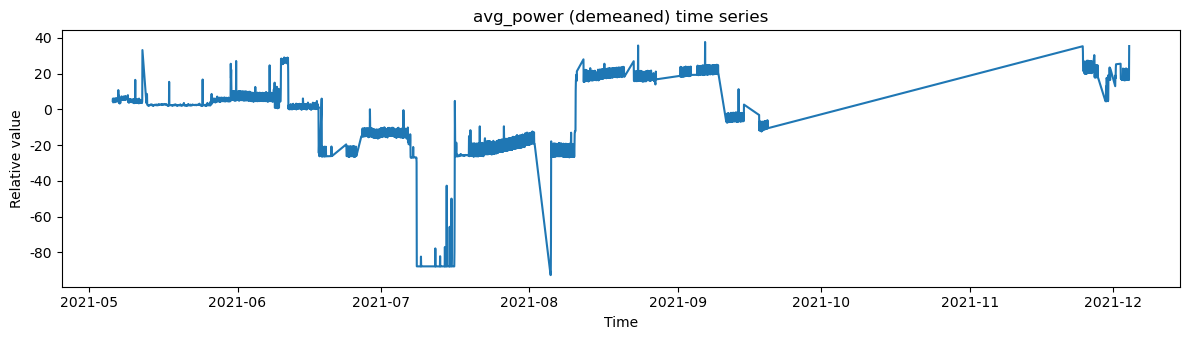

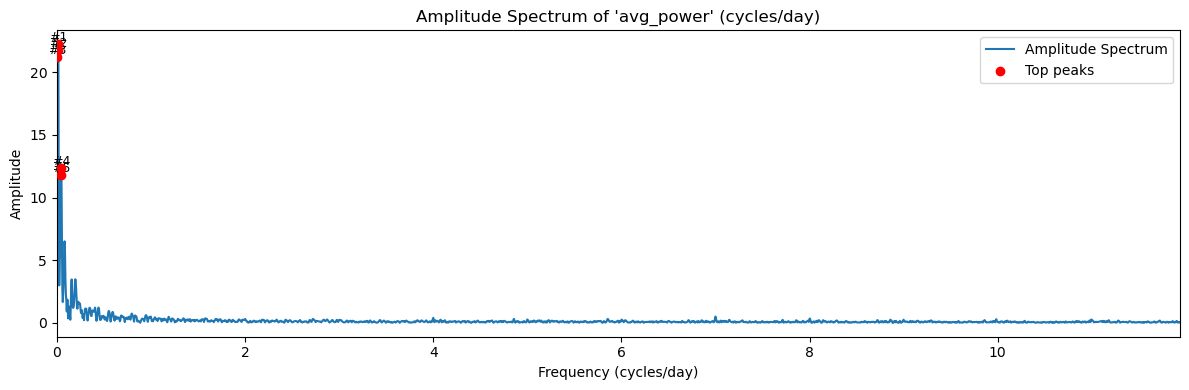

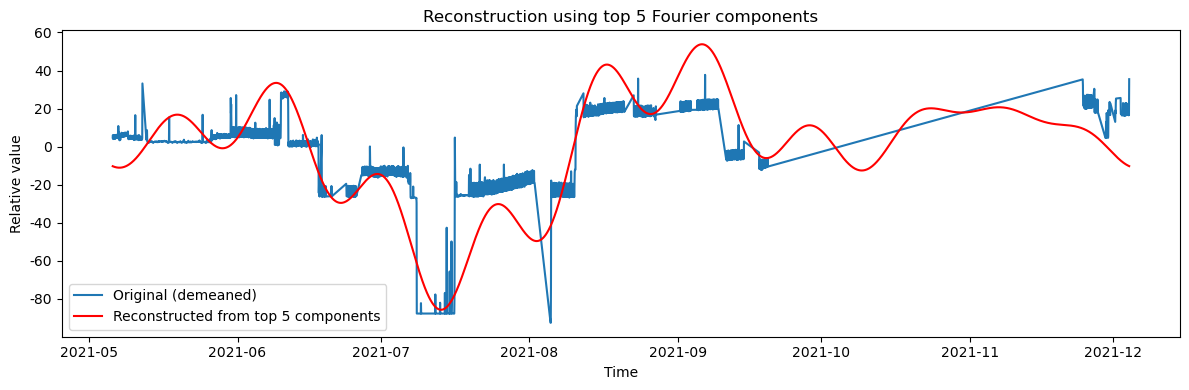

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# ==================== SETTINGS ====================
csv_path = Path("agosto_1h.csv")       # Input CSV file
top_k = 5                               # Number of dominant frequencies to extract
resample_rule = "1H"                    # Sampling frequency (hourly)
time_col = "time"                       # Time column name in CSV
value_col = "avg_power"                 # Value column name in CSV
series_label = value_col                # Label for plots and titles
# ==================================================

# 1) Read and preprocess data
df = pd.read_csv(
    csv_path,
    usecols=[time_col, value_col],
    parse_dates=[time_col]
)
df = df.set_index(time_col).sort_index()

# Resample and interpolate (keeps analysis stable even if gaps exist)
s = (
    pd.to_numeric(df[value_col], errors="coerce")
      .resample(resample_rule).mean()
      .interpolate("time")
)

if len(s) < 2:
    raise ValueError("Not enough data points for FFT analysis.")

dt_hours = (s.index[1] - s.index[0]).total_seconds() / 3600.0

# 2) Demean and apply Hann window
x = s.values.astype(float)
x = x - np.nanmean(x)
window = np.hanning(len(x))
xw = x * window

# 3) FFT
X = np.fft.rfft(xw)
window_correction = np.sum(window) / len(window)
X = X / (len(x) * window_correction)

freq_cph = np.fft.rfftfreq(len(x), d=dt_hours)  # cycles per hour
freq_cpd = freq_cph * 24.0                      # cycles per day
amplitude = np.abs(X)
phase = np.angle(X)
if len(amplitude) > 1:
    amplitude[1:-1] *= 2.0  # restore symmetric energy for real-valued signals (single-sided)

# 4) Find top-k dominant frequencies (excluding DC) + amplitude normalization
mask = freq_cpd > 0
freq_pos = freq_cpd[mask]
amp_pos = amplitude[mask]
phase_pos = phase[mask]

if len(amp_pos) == 0:
    raise ValueError("No valid frequency components found (data may be constant or too short).")

# --- NEW: normalize amplitudes w.r.t. the maximum over positive frequencies (DC excluded)
amp_pos_max = float(np.max(amp_pos)) if amp_pos.size > 0 else 0.0
if amp_pos_max > 0:
    amp_pos_norm = amp_pos / amp_pos_max
else:
    amp_pos_norm = np.zeros_like(amp_pos)

# Select Top-K by raw amplitude (not by normalized value)
idx = np.argsort(amp_pos)[::-1][:top_k]
dominant_freqs = freq_pos[idx]
dominant_amps = amp_pos[idx]
dominant_amps_norm = amp_pos_norm[idx]  # normalized amplitudes for those peaks
dominant_phases = phase_pos[idx]
dominant_period_days = 1.0 / dominant_freqs
dominant_period_hours = dominant_period_days * 24.0

# 5) Print main results
print(f"Sampling interval: {dt_hours:.3f} hours/sample")
print(f"Top {top_k} dominant periods (with phase info):")
print("-----------------------------------------------------------")
for i, (f, a, a_norm, phi, pdays, phours) in enumerate(
    zip(dominant_freqs, dominant_amps, dominant_amps_norm, dominant_phases, dominant_period_days, dominant_period_hours), 1
):
    peak_fraction = (-phi / (2 * np.pi)) % 1.0
    peak_hours = peak_fraction * phours
    print(
        f"{i}. Frequency = {f:.4f} cycles/day, "
        f"Amplitude = {a:,.2f} (norm={a_norm:.4f}), "
        f"Period = {pdays:.3f} days ({phours:.1f} h), "
        f"Phase = {phi:.3f} rad, "
        f"Peak at {peak_fraction*100:.1f}% of cycle (~{peak_hours:.1f} h after start)"
    )

# 6) JSON summary (machine-readable)
results = {
    "resample_rule": str(resample_rule),
    "top_k": int(top_k),
    "n_samples": int(len(x)),
    "sampling_interval_hours": float(dt_hours),
    "time_start": s.index[0].isoformat(),
    "time_end": s.index[-1].isoformat(),
    "value_col": value_col,
    # --- NEW: normalization metadata for reproducibility across datasets
    "amplitude_normalization": {
        "method": "max_of_positive_frequencies",
        "reference_max_amplitude": float(amp_pos_max),
        "note": "amplitude_normalized = amplitude / max(amplitude over positive frequencies; DC excluded)"
    },
    "dominant_components": []
}

for f, a, a_norm, phi in zip(dominant_freqs, dominant_amps, dominant_amps_norm, dominant_phases):
    results["dominant_components"].append({
        "frequency_cycles_per_day": float(f),
        "amplitude": float(a),
        "amplitude_normalized": float(a_norm), 
        "phase_rad": float(phi),
        "peak_fraction_of_cycle": float((-phi / (2 * np.pi)) % 1.0),
        "peak_after_hours_from_start": float(((-phi / (2 * np.pi)) % 1.0) * (24.0 / f)),
    })

print("\n=== JSON summary ===")
print(json.dumps(results, ensure_ascii=False, indent=2))

# 7) Plotting
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

# ---- (A) Demeaned time series
plt.figure(figsize=(12, 3.5))
plt.plot(s.index, x, label=f"Demeaned {series_label}")
plt.title(f"{series_label} (demeaned) time series")
plt.xlabel("Time")
plt.ylabel("Relative value")
plt.tight_layout()
plt.show()

# ---- (B) Amplitude spectrum
plt.figure(figsize=(12, 4))
plt.plot(freq_cpd, amplitude, label="Amplitude Spectrum")
plt.scatter(dominant_freqs, dominant_amps, color="red", zorder=5, label="Top peaks")
for i, f in enumerate(dominant_freqs):
    plt.text(f, dominant_amps[i], f"#{i+1}", fontsize=9, ha='center', va='bottom')
plt.xlim(0, np.percentile(freq_cpd, 99.5))
plt.title(f"Amplitude Spectrum of '{series_label}' (cycles/day)")
plt.xlabel("Frequency (cycles/day)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

# ---- (C) Optional: Reconstruct top components
t = np.arange(len(x)) * dt_hours / 24.0  # time axis in days
reconstructed = np.zeros_like(x)
for f, A, phi in zip(dominant_freqs, dominant_amps, dominant_phases):
    reconstructed += A * np.cos(2 * np.pi * f * t + phi)

plt.figure(figsize=(12, 4))
plt.plot(s.index, x, label="Original (demeaned)")
plt.plot(s.index, reconstructed, label=f"Reconstructed from top {top_k} components", color="red")
plt.title(f"Reconstruction using top {top_k} Fourier components")
plt.xlabel("Time")
plt.ylabel("Relative value")
plt.legend()
plt.tight_layout()
plt.show()
